In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modulesjavascript:void(0);
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Website Scraping

### *Household Expenditure at Restaurants according to new Consumer Expenditure Survey data from the Bureau of Labor Statistics*

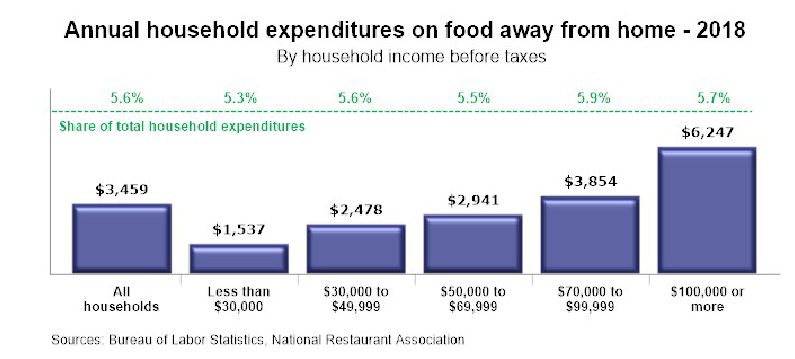

In [2]:
import matplotlib.pyplot as plt
from PIL import Image # converting images into arrays

# download image
!wget --quiet https://restaurant.org/Restaurant/media/Research/Econ%20Notebook/Consumer-Expenditures-Income.jpg
    
# save mask to household_exp
household_exp = np.array(Image.open('Consumer-Expenditures-Income.jpg'))

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(household_exp)
plt.axis('off')
plt.show()

### I am using pandas to read the table into a pandas dataframe.

In [3]:
!pip install lxml
import pandas as pd

In [4]:
url = 'https://en.wikipedia.org/wiki/Cairo_Governorate'
ca_gov = pd.read_html(url)

# Reading the municipal divisions of Cairo governorate using pandas DataFrame
print ("The number of extracted tables from the website are: ", len(ca_gov))

# Our target table is table 3, the Great Cairo Governorate
df_ca_gov = ca_gov[2]

print('Number of rows: ',len(df_ca_gov),'\n')

df_ca_gov = df_ca_gov.drop(['Native name','Arabic transliteration','Type'], axis = 1)
df_ca_gov.head()

The number of extracted tables from the website are:  4
Number of rows:  47 



,Anglicized name,Population(July 2017 Est.)
0,15 May City,93879
1,Abdeen,40450
2,El Darb El Ahmar,58677
3,Ain Shams,616374
4,Amreya,153046


In [5]:
df_ca_gov.columns

Index(['Anglicized name', 'Population(July 2017 Est.)'], dtype='object')

In [6]:
!pip install beautifulsoup4

from bs4 import BeautifulSoup
import requests
import re
import pandas as pd


# Developing table for "AVERAGE RESIDENTIAL PROPERTY PRICES in Egypt" via web scraping  
url = 'https://www.globalpropertyguide.com/Middle-East/Egypt/Price-History'
html = requests.get(url)
bs = BeautifulSoup(html.text,'html.parser')
tbl = bs.find('table')
nameList = tbl.find_all('tr')

tds = []

for e in nameList:
    td = e.get_text()
    td = td[1:].replace("\n","|")
    tds.append(td)

df = pd.DataFrame(tds)
    
df.rename(columns={0:'Neighborhood'}, inplace = True)
df.head()

,Neighborhood
0,AVERAGE RESIDENTIAL PROPERTY PRICES (IN SQ. M....
1,|Apartments|Villas|
2,|EGP|USD|EGP|USD|
3,"New Cairo – Fifth Settlement|9,150|533|17,400|..."
4,"6th of October|5,100|297|12,200|710|"


In [7]:
# Data warehouse report

x=[70,85,85,90,85,90,85,90,95,85,85,120]
y=[60,80,80,80,65,82,78,85,87,77,80,90]
z = [1,2,3,4,5,6,7,8,9,10,11,12]
df_report=pd.DataFrame({'Month':z,'(2a + b)':x,'(a + b)':y})
df_report.set_index('Month', inplace = True)
df_report

,(2a + b),(a + b)
Month,,
1,70,60
2,85,80
3,85,80
4,90,80
5,85,65
6,90,82
7,85,78
8,90,85
9,95,87


## 2. Data Wrangling

In [8]:
# Rename the column "Anglicized name" to "Neighborhood"
df_ca_gov.rename(columns={'Anglicized name':'Neighborhood'}, inplace = True)

# Rename the column "Neighbourhood" to "Neighborhood"
df_ca_gov.rename(columns={'Population(July 2017 Est.)':'Population'}, inplace = True)
df_ca_gov.sort_values(['Population'], ascending=False, axis=0, inplace=True)
df_ca_gov.reset_index(drop=True, inplace=True)

df_ca_gov.head()

,Neighborhood,Population
0,El Marg,801222
1,Nasr City 1,636864
2,Ain Shams,616374
3,El Matareya,604428
4,Dar El Salam,527335


In [9]:
import pandas as pd

# Extracting neighborhoods' name for RESIDENTIAL PROPERTY in Egypt
area = df['Neighborhood'].str.split('|').str[0]
df_area = pd.DataFrame(area)

# Extracting AVERAGE RESIDENTIAL PROPERTY PRICES
price = df['Neighborhood'].str.split('|').str[1]
df_price = pd.DataFrame(price)
df_price.rename(columns={'Neighborhood':'Price_Sqm'}, inplace = True)


# merge the two tables to get the neighborhood's land price per meter-squared
lan_price = pd.concat([df_area, df_price], axis=1)

lan_price = lan_price[3:(len(df)-1)]
lan_price.sort_values(['Price_Sqm'], ascending=False, axis=0, inplace=True)
lan_price.reset_index(drop=True, inplace=True)
lan_price.head(10)
Neighbrs_pr = lan_price.head(20)
Neighbrs_pr

,Neighborhood,Price_Sqm
0,New Administrative Capital,"9,400"
1,El Mohandeseen,"9,200"
2,New Cairo – Fifth Settlement,"9,150"
3,El Sheikh Zayed City,"8,850"
4,El Agouza,"8,200"
5,Heliopolis – Masr El Gedida,"6,800"
6,El Maadi,"6,050"
7,Nasr City,"5,850"
8,Shoubra,"5,600"
9,El Abbasiya,"5,550"


## 3. Geographical coordinates of Great Cairo Neighborhoods

In [10]:
!pip install geocoder
import geocoder

geolocator = Nominatim(user_agent="Cairo_explorer")

city = 'Cairo, Egypt'

no_loc = []
neighbrs_loc = []
neighborhoods  = lan_price['Neighborhood']   # neighborhoods list based on most average residential property in Egypt 

for i in neighborhoods:
    address = i + ', ' + city    
    try:
        location = geolocator.geocode(address)
        lat = location.latitude
        lng = location.longitude
        
    except:
        no_loc.append(address)    
        
    neighbrs_loc.append([address, lat, lng])
        
neighbrs_loc[:5]

[['New Administrative Capital, Cairo, Egypt', 30.0248713, 31.7768032],
 ['El Mohandeseen, Cairo, Egypt', 30.07621785, 31.35007243798075],
 ['New Cairo – Fifth Settlement, Cairo, Egypt',
  30.07621785,
  31.35007243798075],
 ['El Sheikh Zayed City, Cairo, Egypt', 30.048347, 30.9832235],
 ['El Agouza, Cairo, Egypt', 30.0549435, 31.2127281]]

In [11]:
# neighborhoods without location, where geolocator could not match the neighborhood's name 
df_no_loc = pd.DataFrame(no_loc)
df_no_loc

,0
0,"New Cairo – Fifth Settlement, Cairo, Egypt"
1,"Heliopolis – Masr El Gedida, Cairo, Egypt"
2,"El Hadabah El Wosta, Cairo, Egypt"
3,"El Koba Gardens, Cairo, Egypt"
4,"El Oubour, Cairo, Egypt"
5,"El Jizah District, Cairo, Egypt"


In [12]:
# Due to six names mismatch, searching for the location and developing dataframe table for them
add_loc = [[30.026300, 31.496773], [30.090984, 31.322708], [29.992201, 31.317760], [30.096263, 31.303912], 
           [30.229736, 31.479492], [30.013109, 31.208802]]

Latitudes = [add_loc[i][0] for i in range(0,6)]
Longitudes = [add_loc[i][1] for i in range(0,6)]
df_no_loc["Latitude"] = Latitudes
df_no_loc["Longitude"] = Longitudes

In [13]:
df_no_loc.rename(columns={0:'Neighborhood'}, inplace = True)
df_no_loc

,Neighborhood,Latitude,Longitude
0,"New Cairo – Fifth Settlement, Cairo, Egypt",30.026300,31.496773
1,"Heliopolis – Masr El Gedida, Cairo, Egypt",30.090984,31.322708
2,"El Hadabah El Wosta, Cairo, Egypt",29.992201,31.317760
3,"El Koba Gardens, Cairo, Egypt",30.096263,31.303912
4,"El Oubour, Cairo, Egypt",30.229736,31.479492
5,"El Jizah District, Cairo, Egypt",30.013109,31.208802


In [14]:
# Working with geocoder generated table, and combining it with the missing location in new dataframe table
neighbrs_Geo = []

for i in range(0,len(neighbrs_loc)):
    neighbr_Geo = {"Neighborhood":neighbrs_loc[i][0], "Latitude":neighbrs_loc[i][1], "Longitude":neighbrs_loc[i][2]}
    neighbrs_Geo.append(neighbr_Geo)
    
neighbrs_Geo = pd.DataFrame(neighbrs_Geo)
neighbrs_Geo.set_index(['Neighborhood'], inplace = True)

#Removing neighborhoods with no location, by dropping the row if it contains any the following neighborhood's name (no_loc) 
neighbrs_Geo.drop(no_loc, inplace = True)

# Reset index
neighbrs_Geo.reset_index(inplace = True)

# We append rows of the six missing neighborhood locations from one DataFrame table to another. 
neighbrs_Geo = pd.concat([neighbrs_Geo, df_no_loc], axis=0)
neighbrs_Geo.reset_index(drop = True, inplace = True)

neighbrs_Geo

,Neighborhood,Latitude,Longitude
0,"New Administrative Capital, Cairo, Egypt",30.024871,31.776803
1,"El Mohandeseen, Cairo, Egypt",30.076218,31.350072
2,"El Sheikh Zayed City, Cairo, Egypt",30.048347,30.983224
3,"El Agouza, Cairo, Egypt",30.054944,31.212728
4,"El Maadi, Cairo, Egypt",29.960331,31.263055
5,"Nasr City, Cairo, Egypt",30.052118,31.342205
6,"Shoubra, Cairo, Egypt",30.078500,31.243305
7,"El Abbasiya, Cairo, Egypt",30.066667,31.283333
8,"Mokattam, Cairo, Egypt",30.033333,31.283333
9,"New Heliopolis, Cairo, Egypt",30.118097,31.692560


### *Find the distance from "El Agouza, Cairo" - my first service branch - to every neighborhood. Distances over 12Km is not recommended*

In [15]:
import geopy.distance

Dist = []

for i in range(0,len(neighbrs_Geo)):
    coords_ref = (neighbrs_Geo.iloc[3,1], neighbrs_Geo.iloc[3,2])
    coords_nei = (neighbrs_Geo.iloc[i,1], neighbrs_Geo.iloc[i,2])
    D = geopy.distance.distance(coords_ref, coords_nei).km
    Dist.append(D)

neighbrs_Geo['Distance'] = Dist
neighbrs_Geo

,Neighborhood,Latitude,Longitude,Distance
0,"New Administrative Capital, Cairo, Egypt",30.024871,31.776803,54.505700
1,"El Mohandeseen, Cairo, Egypt",30.076218,31.350072,13.451469
2,"El Sheikh Zayed City, Cairo, Egypt",30.048347,30.983224,22.144643
3,"El Agouza, Cairo, Egypt",30.054944,31.212728,0.000000
4,"El Maadi, Cairo, Egypt",29.960331,31.263055,11.557422
5,"Nasr City, Cairo, Egypt",30.052118,31.342205,12.489914
6,"Shoubra, Cairo, Egypt",30.078500,31.243305,3.938406
7,"El Abbasiya, Cairo, Egypt",30.066667,31.283333,6.931173
8,"Mokattam, Cairo, Egypt",30.033333,31.283333,7.218492
9,"New Heliopolis, Cairo, Egypt",30.118097,31.692560,46.783742


### Removing "Cairo, Egypt" from Neighborhood column, adding price/Sqm column, and sorting 

In [16]:
# Removing "Cairo, Egypt" from Neighborhood column
neighbrs_Geo['Neighborhood'] = neighbrs_Geo['Neighborhood'].str.split(',').str[0]

# Combining two DataFrame tables, Table(neighbrs_geoloc) & table (Neighbrs_pr)
neighbrs_geoloc = pd.merge(left=neighbrs_Geo, right=Neighbrs_pr, how='left', left_on='Neighborhood', right_on='Neighborhood')

# Sorting the table according to price/square meter.
neighbrs_geoloc.sort_values(['Price_Sqm'], ascending=False, axis=0, inplace = True)

# Set "Neighborhood" index
neighbrs_geoloc.set_index(['Neighborhood'], inplace = True)

neighbrs_geoloc

,Latitude,Longitude,Distance,Price_Sqm
Neighborhood,,,,
New Administrative Capital,30.024871,31.776803,54.505700,"9,400"
El Mohandeseen,30.076218,31.350072,13.451469,"9,200"
New Cairo – Fifth Settlement,30.026300,31.496773,27.578656,"9,150"
El Sheikh Zayed City,30.048347,30.983224,22.144643,"8,850"
El Agouza,30.054944,31.212728,0.000000,"8,200"
Heliopolis – Masr El Gedida,30.090984,31.322708,11.331458,"6,800"
El Maadi,29.960331,31.263055,11.557422,"6,050"
Nasr City,30.052118,31.342205,12.489914,"5,850"
Shoubra,30.078500,31.243305,3.938406,"5,600"


#### *Three conditions should exist in the proposed new neighborhood to place my 2nd service branch as following: first, Residential price/Sqm should be above 6k to address high customer segment. Second, the invested cost in Residential price/Sqm should not exceed 8k for positive NPV. Third, the location distance from my first branch should not exceed 12km in case of service support given from my first branch.*

### This limit our options into "El Maadi & Heliopolis". I will go for "El Maadi" neighborhood.


# *Explore and cluster venues in "Maadi" neighborhood*

In [17]:
# Use geopy library to get the latitude and longitude values of Cairo

address = 'Cairo, Egypt'

geolocator = Nominatim(user_agent="Cairo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('{} geograpical location = {}, {}.'.format(address, latitude, longitude))

Cairo, Egypt geograpical location = 30.048819, 31.243666.


## Great Cairo & surrounding governorates with neighborhoods superimposed on top

In [18]:
# create map of Cairo to using latitude and longitude values
map_Cairo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighbrs_geoloc['Latitude'], neighbrs_geoloc['Longitude'], neighbrs_geoloc.index):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_Cairo)  
    
map_Cairo

## Define Foursquare Credentials and Version
We are going to start utilizing the Foursquare API to explore the neighborhoods and segment them

In [19]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
ACCESS_TOKEN = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # my access token 
VERSION = '20180605' # Foursquare API version


## Explore "El Maadi" neighbrourhood in our dataframe.

In [20]:
# Get Maadi neighbourhoods' latitude and longitude values

#neighborhood_name = neighbrs_geoloc.loc['El Maadi', 'Neighborhood'] # neighborhood name
neighborhood_latitude = neighbrs_geoloc.loc['El Maadi', 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighbrs_geoloc.loc['El Maadi', 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values are {}, {}.'.format(neighborhood_latitude,
                                                         neighborhood_longitude))

Latitude and longitude values are 29.9603313, 31.26305504108212.


In [21]:
Latitude = neighbrs_geoloc.loc['El Maadi', 'Latitude']
Longitude = neighbrs_geoloc.loc['El Maadi', 'Longitude']

*Now, let's get the top 100 venues that are in "The Maadi" within a radius of 1500 meters*

In [22]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [23]:
results = requests.get(url).json()['response']['groups'][0]['items']

*We will build a function called **get_category_type** to extracts the category of the venue*

In [24]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [25]:
# Clean the json, get the information under the *items* key, and structure it into a pandas dataframe. 

# flatten JSON
nearby_venues = pd.json_normalize(results)

# filter columns for venue: name, categories, lat, lng
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
#nearby_venues = pd.DataFrame(nearby_venues)
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,El Qahwa Khan,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",29.960822,31.264985
1,Gold's Gym,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",29.959940,31.259918
2,NOLA Cupcakes (نولا),"[{'id': '4bf58dd8d48988d1bc941735', 'name': 'C...",29.958510,31.259526
3,Villa Belle Epoque (Villa Belle Epoque | فيلا ...,"[{'id': '4bf58dd8d48988d1f8931735', 'name': 'B...",29.959463,31.263092
4,Maadi Club (نادي المعادي الرياضي),"[{'id': '52e81612bcbc57f1066b7a2e', 'name': 'S...",29.964020,31.263031


In [26]:
# filter the column category for each row by extracting only the category "name" for each venue.
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns (by keeping only the last section name for each column name)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]



# Rename columns name
nearby_venues.rename(columns={'name':'Venue','categories':'Category','lat':'Latitude','lng':'Longitude'}, inplace = True)

print('\n','"{}" venues were returned by Foursquare as follows:'.format(nearby_venues.shape[0]),'\n')

nearby_venues.head()


 "100" venues were returned by Foursquare as follows: 



,Venue,Category,Latitude,Longitude
0,El Qahwa Khan,Café,29.960822,31.264985
1,Gold's Gym,Gym / Fitness Center,29.959940,31.259918
2,NOLA Cupcakes (نولا),Cupcake Shop,29.958510,31.259526
3,Villa Belle Epoque (Villa Belle Epoque | فيلا ...,Bed & Breakfast,29.959463,31.263092
4,Maadi Club (نادي المعادي الرياضي),Sports Club,29.964020,31.263031


#### *The number of unique categories and the number of each category*

In [27]:
print('There are {} uniques categories.'.format(len(nearby_venues['Category'].unique())))

There are 48 uniques categories.


In [28]:
print(len(nearby_venues),'\n')
venues_count = pd.DataFrame(nearby_venues['Category'].value_counts())
venues_count = venues_count.reset_index().rename(columns={'index':'venue','Category':'count' })
venues_count.head()

100 



,venue,count
0,Café,12
1,Restaurant,7
2,Italian Restaurant,7
3,Coffee Shop,6
4,Ice Cream Shop,4


In [29]:
# Convert the word & count columns to a dict
venues_count = dict(zip(venues_count['venue'].tolist(), venues_count['count'].tolist()))
print(venues_count)

{'Café': 12, 'Restaurant': 7, 'Italian Restaurant': 7, 'Coffee Shop': 6, 'Ice Cream Shop': 4, 'Bookstore': 4, 'Middle Eastern Restaurant': 4, 'Lounge': 3, 'Pastry Shop': 3, 'Indian Restaurant': 2, 'American Restaurant': 2, 'German Restaurant': 2, 'Gym / Fitness Center': 2, 'Burger Joint': 2, 'Supermarket': 2, 'Bakery': 2, 'Asian Restaurant': 2, 'Sushi Restaurant': 2, 'Modern European Restaurant': 2, 'Lebanese Restaurant': 2, 'Gourmet Shop': 1, 'Sports Club': 1, 'Plaza': 1, 'Track': 1, 'Yoga Studio': 1, 'Steakhouse': 1, 'Community Center': 1, 'Deli / Bodega': 1, 'Pizza Place': 1, 'Moroccan Restaurant': 1, 'Eye Doctor': 1, 'Food Stand': 1, 'Bed & Breakfast': 1, 'Jewelry Store': 1, 'Latin American Restaurant': 1, 'Stationery Store': 1, 'Thai Restaurant': 1, 'Juice Bar': 1, 'Creperie': 1, 'Candy Store': 1, 'Convenience Store': 1, 'Chocolate Shop': 1, 'Bagel Shop': 1, 'Cupcake Shop': 1, 'Hotel': 1, 'Cuban Restaurant': 1, 'Chinese Restaurant': 1, 'Syrian Restaurant': 1}


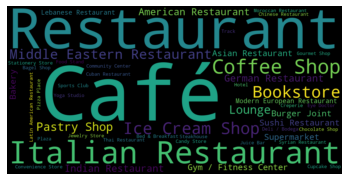

In [30]:
#install and import wordcloud
!pip install wordcloud
from wordcloud import WordCloud
import imageio

venues_cloud = WordCloud(width=1200, height=600).generate_from_frequencies(venues_count)

# Visualize the word cloud
import matplotlib.pyplot as plt
plt.imshow(venues_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3. Clustering

Creating a new dataframe that includes the cluster.

## *DBSCAN, Finding the Optimal Value For Epsilon (EPS)*

In [31]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [32]:
nearby_venues = nearby_venues.sort_values(by=['Latitude', 'Longitude'])
nearby_venues = nearby_venues.reset_index(drop=True)
nearby_venues.head()

,Venue,Category,Latitude,Longitude
0,Kazouza (كازوزه),Middle Eastern Restaurant,29.950858,31.266704
1,Desoky & Soda,Restaurant,29.950922,31.266674
2,IL Pennello Ceramic Café,Café,29.950988,31.266752
3,Barista,Italian Restaurant,29.951569,31.265620
4,Ralph’s German Bakery,Bakery,29.951771,31.265444


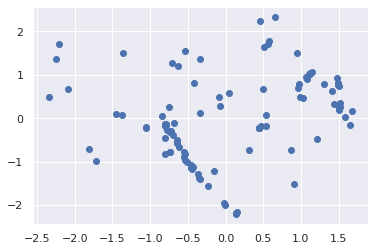

In [33]:
# Creating table for venue coordination of (Latitude & Longitude) and plot it to get a sense of what it looks like
coords = nearby_venues.values[:,2:]  # Latitude in column(2) & Longitude in column(3)

# Change dtype from object to float
coords = coords.astype("float")

# normalizing the data
from sklearn.preprocessing import StandardScaler
coords = StandardScaler().fit_transform(coords)

#ax = nearby_venues.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.8, linewidth=0)
plt.scatter(coords[:,1], coords[:,0])

In [34]:
neigh = NearestNeighbors(n_neighbors=2) # two means the point itself plus one nearest point
nbrs = neigh.fit(coords)
distances, indices = nbrs.kneighbors(coords)

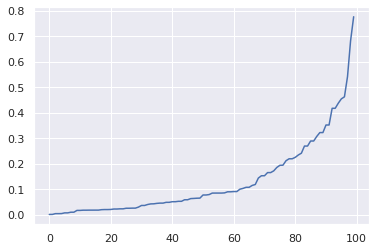

In [35]:
distances = np.sort(distances, axis=0)
distances = distances[:,1] # First column is the point itself, where the second column is the second nearest point
plt.plot(distances)

### *The best epsilon is between (0.45-0.5)*

In [36]:
epsilon =0.45

# Compute DBSCAN
db = DBSCAN(eps=epsilon ,min_samples =5).fit(coords)
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(unique_labels))
print('Number  of  clusters: {}'.format(num_clusters))
print('Clusters label are: {}'.format(unique_labels))

Number  of  clusters: 4
Clusters label are: {0, 1, 2, -1}


#### *Venue of Cluster Lable of (-1) means that this venue is outlier*

In [37]:
nearby_venues["Clus_Db"]=cluster_labels
venue_cluster = nearby_venues[['Category','Clus_Db']]

# Counting each cluster number
venue_cluster = venue_cluster.groupby('Clus_Db').count()
venue_cluster.columns=['venues_count']
venue_cluster

,venues_count
Clus_Db,
-1,25
0,45
1,6
2,24


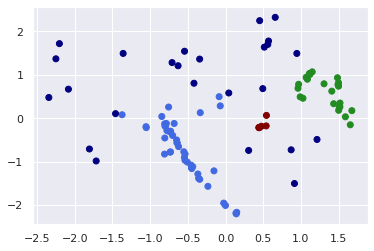

In [38]:
# Then, we map every individual cluster to a color.
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod',
          'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(coords[:,1], coords[:,0], c=vectorizer(cluster_labels))

### Displaying Maadi map with clustered neighborhoods superimposed on top

In [39]:
# Maadi goegraphical location
Latitude = 29.960572 
Longitude = 31.264950 
print(Latitude,Longitude)

29.960572 31.26495


## Visualizing the resulting clusters

In [40]:
# Matplotlib and associated plotting modulesjavascript:void(0);
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
maadi_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=14)
print(Latitude,Longitude)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, ven, cluster in zip(nearby_venues['Latitude'], nearby_venues['Longitude'], nearby_venues['Venue'], nearby_venues['Clus_Db']):
    
    label = folium.Popup(str(ven) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,        
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8,
        parse_html=False).add_to(maadi_clusters)
    
           
maadi_clusters



29.960572 31.26495


## Visualizing the resulting clusters

## 5. Examine Clusters

Cluster 1

In [41]:
nearby_venues.loc[nearby_venues['Clus_Db'] == 0,:]

,Venue,Category,Latitude,Longitude,Clus_Db
0,Kazouza (كازوزه),Middle Eastern Restaurant,29.950858,31.266704,0
1,Desoky & Soda,Restaurant,29.950922,31.266674,0
2,IL Pennello Ceramic Café,Café,29.950988,31.266752,0
3,Barista,Italian Restaurant,29.951569,31.265620,0
4,Ralph’s German Bakery,Bakery,29.951771,31.265444,0
5,Wienerwald (وينروالد),German Restaurant,29.953197,31.263859,0
7,Khayrat El Sham (خيرات الشام),Syrian Restaurant,29.953793,31.263039,0
8,Union Lounge,American Restaurant,29.953875,31.262927,0
9,Man'oucheh (منقوشة),Lebanese Restaurant,29.954246,31.262852,0
10,Ma7ali,Deli / Bodega,29.954512,31.264467,0


Cluster 2

In [42]:
nearby_venues.loc[nearby_venues['Clus_Db'] == 1,:]

,Venue,Category,Latitude,Longitude,Clus_Db
38,Asian Corner,Asian Restaurant,29.958186,31.268993,1
39,La Casetta,Italian Restaurant,29.958186,31.269008,1
41,Ovio,Modern European Restaurant,29.958199,31.268963,1
43,Frank & Co,Lounge,29.958307,31.269221,1
45,Steel Fitness Club,Gym / Fitness Center,29.958336,31.269701,1
53,Palazzo Lounge,Italian Restaurant,29.959230,31.269728,1


Cluster 3

In [43]:
nearby_venues.loc[nearby_venues['Clus_Db'] == 2,:]

,Venue,Category,Latitude,Longitude,Clus_Db
47,Wanted,Coffee Shop,29.958430,31.278135,2
51,Akasya,Modern European Restaurant,29.959109,31.277646,2
57,Micah's Grill & Jared's Bagels,Bagel Shop,29.959635,31.278293,2
58,La Rosa,Italian Restaurant,29.959662,31.276967,2
59,Cafe Mo,Café,29.959899,31.277039,2
61,Sizzler,Steakhouse,29.959963,31.277094,2
63,Diwan Bookstore,Bookstore,29.960223,31.276470,2
64,Crave (كريف),Restaurant,29.960285,31.277105,2
65,Seoudi (سعودي),Supermarket,29.960688,31.273391,2
67,Dunes,Moroccan Restaurant,29.960807,31.273110,2


Excluded venues (Outliers)

In [44]:
nearby_venues.loc[nearby_venues['Clus_Db'] == -1,:]

,Venue,Category,Latitude,Longitude,Clus_Db
6,House of Cocoa,Chocolate Shop,29.953436,31.272539,-1
16,Grand Café (Grand Cafe),Café,29.955353,31.252655,-1
24,Mustafa Kamel Sq (ميدان مصطفي كامل),Plaza,29.956250,31.267944,-1
25,Genghis Khan Restaurant,Chinese Restaurant,29.956301,31.272207,-1
26,Mandarine Koueider,Pastry Shop,29.956372,31.251979,-1
31,Beano's Cafe,Café,29.957182,31.274799,-1
55,El Horreya Cafe (كافيه الحرية),Café,29.959378,31.254597,-1
66,Holiday Inn Cairo Maadi,Hotel,29.960753,31.247909,-1
69,The Tipsy Teapot (ذا تيبسي تيبوت),Lounge,29.961136,31.265951,-1
71,Creperie des Arts (كريبيري ديز ارت),Creperie,29.961461,31.249871,-1


# *Inventory Management for Spare Part Management Service (SPMS)*

In [45]:
import pandas as pd
import numpy as np
from scipy.stats import triang 
import matplotlib.pyplot as plt  

### Calculating the amount of combined spare part of items a&b using Triangular probability distribution

In [46]:
# Defining the required percentage for likelihood of occurance for number of spare parts a & b

# For the case of (2a + b)
m = 70          # minimum
n = 85          # mode
k = 120         # maximum
prob_ab = 0.8   # for minimum likelihood of occurance 

x=np.linspace(m,k,(k-m)*2)
x=np.nan_to_num(x)
x=x.tolist()

c = (n-m)/(k-m) 
loc = m
scale = k-m 
y = triang.cdf(x, c, loc, scale) 
y = y.tolist()
cdf = pd.DataFrame({'Item_ab':x,'CDF':y})  
cdf.head()

Item_ab = cdf.loc[cdf['CDF'] > prob_ab].iloc[0,0]
print('For {} likelihood of occurance: '.format(prob_ab))
print('The quantity of combined items of (2a + b) >= {} item'.format(Item_ab))

For 0.8 likelihood of occurance: 
The quantity of combined items of (2a + b) >= 101.31313131313132 item


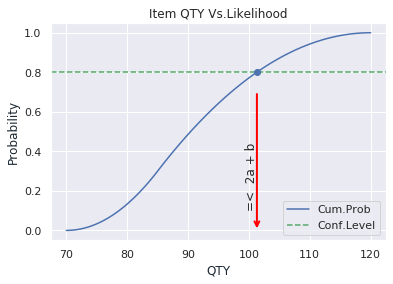

In [47]:
plt.plot(x, y, '-b', label='Cum.Prob')
plt.axhline(y=prob_ab, color='g', linestyle='--', label='Conf.Level')
plt.plot(Item_ab, prob_ab, Marker='o')
plt.title('Item QTY Vs.Likelihood')
plt.xlabel('QTY', color='#1C2833')
plt.ylabel('Probability', color='#1C2833')
plt.legend(loc='lower right')

# Annotate arrow
plt.annotate('',                      
             xy=(Item_ab, 0),             
             xytext=(Item_ab, prob_ab-.1),         
             xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red', lw=2)
            )

# Annotate Text
plt.annotate('=<  2a + b', # text to display
             xy=(Item_ab-2, 0.1),                   
             rotation=90,                  
             va='bottom',                    
             ha='left',                      
            )
plt.show()

In [48]:
# For the case of (a + b)
m = 60          # minimum
n = 70          # mode
k = 90         # maximum
prob_ab = 0.8   # for minimum likelihood of occurance 

x=np.linspace(m,k,(k-m)*2)
x=np.nan_to_num(x)
x=x.tolist()

c = (n-m)/(k-m) 
loc = m
scale = k-m 
y = triang.cdf(x, c, loc, scale) 
y = y.tolist()
cdf = pd.DataFrame({'Item_ab':x,'CDF':y})  
cdf.head()

Item_ab = cdf.loc[cdf['CDF'] > prob_ab].iloc[0,0]
print('For {} likelihood of occurance: '.format(prob_ab))
print('The quantity of combined items of (a + b) >= {} item'.format(Item_ab))

For 0.8 likelihood of occurance: 
The quantity of combined items of (a + b) >= 79.32203389830508 item


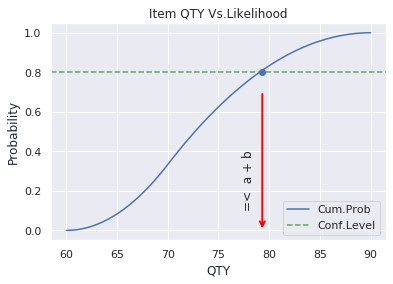

In [49]:
plt.plot(x, y, '-b', label='Cum.Prob')
plt.axhline(y=prob_ab, color='g', linestyle='--', label='Conf.Level')
plt.plot(Item_ab, prob_ab, Marker='o')
plt.title('Item QTY Vs.Likelihood')
plt.xlabel('QTY', color='#1C2833')
plt.ylabel('Probability', color='#1C2833')
plt.legend(loc='lower right')

# Annotate arrow
plt.annotate('',                      
             xy=(Item_ab, 0),             
             xytext=(Item_ab, prob_ab-.1),         
             xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red', lw=2)
            )

# Annotate Text
plt.annotate('=<  a + b', # text to display
             xy=(Item_ab-2, 0.1),                   
             rotation=90,                  
             va='bottom',                    
             ha='left',                      
            )
plt.show()

In [50]:
!pip install pulp

In [51]:
import pulp
a = pulp.LpVariable('a', lowBound=0)
b = pulp.LpVariable('b', lowBound=0)

problem = pulp.LpProblem('A simple minimization objective',pulp.LpMinimize)
problem += 3*a + 2*b, 'The objective function'
problem += 2*a + b >= 102, '1st constraint'
problem += a + b >= 80, '2nd constraint'
problem += a <= 41, '3rd constraint'
problem.solve()

print("Minimization_Results:")
for variable in problem.variables():
    print(variable.name,'=', variable.varValue)

Minimization_Results:
a = 22.0
b = 58.0


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


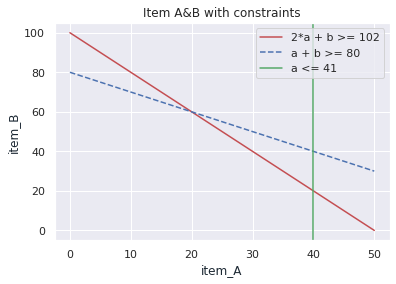

In [52]:
import matplotlib.pyplot as plt
import numpy as np
a = np.linspace(0,50)
plt.plot(a, 100 - 2*a, '-r', label='2*a + b >= 102')
plt.plot(a, 80 - a, '-b', linestyle='--', label='a + b >= 80')
plt.axvline(x=40, color='g', label='a <= 41')
plt.title('Item A&B with constraints')
plt.xlabel('item_A', color='#1C2833')
plt.ylabel('item_B', color='#1C2833')
plt.legend(loc='upper right')
#plt.grid()
plt.show()

In [53]:
# alternative way of ploting A&B
import pandas as pd
import numpy as np
x=range(0,51)
x=np.nan_to_num(x)
y=100-2*x
y=y.tolist()
x=x.tolist()
df_AB=pd.DataFrame({'Item_(A)':x,'item_(B)':y})
df_AB.head()

,Item_(A),item_(B)
0,0,100
1,1,98
2,2,96
3,3,94
4,4,92


In [54]:
import pulp
c = pulp.LpVariable('c', lowBound=0)
d = pulp.LpVariable('d', lowBound=0)

problem = pulp.LpProblem('A simple minimization objective',pulp.LpMinimize)
problem += 2*c + 5*d, 'The objective function'
problem += c + 3*d >= 250, '1st constraint'
problem += c + 2*d >= 180, '2nd constraint'
problem += d <= 65, '3rd constraint'
problem.solve()

print("Minimization Results:")
for variable in problem.variables():
    print(variable.name, '=', variable.varValue)

Minimization Results:
c = 55.0
d = 65.0


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


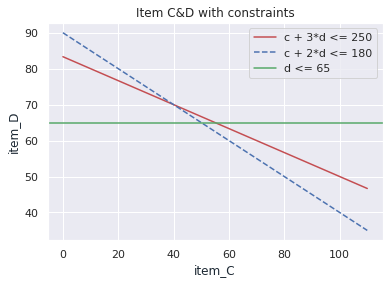

In [55]:
import matplotlib.pyplot as plt
import numpy as np
c = np.linspace(0,110)
plt.plot(c, (250 - c)/3, '-r', label='c + 3*d <= 250')
plt.plot(c, (180 - c)/2, '-b', linestyle='--', label='c + 2*d <= 180')
plt.axhline(y=65, color='g', label='d <= 65')
plt.title('Item C&D with constraints')
plt.xlabel('item_C', color='#1C2833')
plt.ylabel('item_D', color='#1C2833')
plt.legend(loc='upper right')
#plt.grid()
plt.show()